## CatBoost 설치와 라이브러리 로딩  
Catboost는 GPU 환경에서만 학습이 가능하므로, colab의 경우는  
런타임 유형을 GPU로 바꿔주도록한다.

### Install CatBoost 

In [0]:
!pip install catboost

### Import libraries  
*구글 드라이브와 연동하기 위해 drive.mount를 사용한다.  
*/content/gdrive/ 이후 디렉터리는 사용자에 따라 다르게 설정해주도록 한다.

In [0]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## 데이터 셋 로딩과 전처리

In [0]:
#MyDrive/ 이후의 디렉터리는 사용자에 따라 다르므로 유의 할 것
AFSNT=pd.read_csv('/content/gdrive/My Drive/test_colab/AFSNT.csv',encoding = "ISO-8859-1")
AFSNT.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR
0,2017,1,1,ÀÏ,ARP3,ARP6,J,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN
1,2017,1,1,ÀÏ,ARP3,ARP6,J,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN
2,2017,1,1,ÀÏ,ARP3,ARP6,J,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN
3,2017,1,1,ÀÏ,ARP3,ARP6,J,J1957,SEw3NzE4,D,N,13:25,14:09,Y,C02,N,NaN
4,2017,1,1,ÀÏ,ARP3,ARP6,J,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN


### 결항편과 소수 공항 제거  
소수 공항은 한국 공항 공사 스케줄과 매칭 되지않아서 제외하였다.

In [0]:
#결항 및 소수 공항 제거
drop_list=['C','D','E','G','K']
AFSNT=AFSNT[AFSNT['CNL']=='N']
for i in drop_list:
  AFSNT=AFSNT[AFSNT['FLO']!=i]

### Preprocessing
1.SDT_YY,MM,DD를 묶어 통합날짜(DATE) 열 생성  
2.DATE 열을 이용해 요일(Weekday) 열 생성  
3.ATT와 STT의 차이를 구한 시간차(INT) 열 생성  
4.전처리 후 사용할 일부 칼럼만 추출

In [0]:
def weekdayn(Date):
  return Date.weekday()

def getValuebyminute(STT):
  hour,minute=STT.split(':')
  hour=float(hour)
  minute=float(minute)
  return hour*60+minute
# 1.통합 날짜 열 생성
AFSNT=AFSNT.rename(columns={'SDT_YY':'Year','SDT_MM':'Month','SDT_DD':'Day'})
AFSNT['DATE']=pd.to_datetime(AFSNT.loc[:, ['Year','Month','Day']])

# 2. 요일 열 생성
AFSNT['Weekday']=AFSNT['DATE'].apply(weekdayn)

# 3. INT 열 생성
##날짜를 포한 계획, 실제 시간의 시각 값만 추출, 하루가 넘어간 열(24:00 이후 도착)의 인덱스 추출
STT_hour=AFSNT['STT'].str.split(':').str.get(0).astype('float64')
ATT_hour=AFSNT['ATT'].str.split(':').str.get(0).astype('float64')
DLY=AFSNT['DLY'].str.get(0)

##하루가 넘어간 열의 인덱스 추출
over_time_idx=AFSNT.loc[(STT_hour>ATT_hour)&(DLY=='Y'),:].index

##날짜 포함 열 생성
AFSNT['STT_detail']=pd.to_datetime(AFSNT['DATE'].astype('str')+' '+AFSNT['STT'])
AFSNT['ATT_detail']=pd.to_datetime(AFSNT['DATE'].astype('str')+' '+AFSNT['ATT'])
AFSNT['STT']=AFSNT['STT'].apply(getValuebyminute)
#하루를 더한다
AFSNT.loc[over_time_idx,'ATT_detail']=AFSNT.loc[over_time_idx,'ATT_detail']+pd.DateOffset(days=1)

#4. 칼럼추출
AFSNT['INT']=AFSNT['ATT_detail']-AFSNT['STT_detail']
AFSNT['INT']=pd.to_timedelta(AFSNT['INT'],unit='m').astype('timedelta64[m]')
AFSNT=AFSNT.loc[:,['DATE','ARP','ODP','FLO','AOD','IRR','Month','Weekday','STT','ATT','INT','DLY']]
AFSNT.head()

,DATE,ARP,ODP,FLO,AOD,IRR,Month,Weekday,STT,ATT,INT,DLY
0,2017-01-01,ARP3,ARP6,J,D,N,1,6,605.0,10:32,27.0,N
1,2017-01-01,ARP3,ARP6,J,A,N,1,6,570.0,9:31,1.0,N
2,2017-01-01,ARP3,ARP6,J,A,N,1,6,765.0,13:03,18.0,N
3,2017-01-01,ARP3,ARP6,J,D,N,1,6,805.0,14:09,44.0,Y
4,2017-01-01,ARP3,ARP6,J,A,N,1,6,970.0,16:31,21.0,N


### 백분위수 1%, 99% 이상의 시간차를 이상치 처리  
밑에 보다시피 상위 99%의 INT 값은 93분이지만, 최대값은 765분이다.
산포가 많이 불균일하므로 이상치 제거를 해준다.

In [0]:
print(AFSNT.INT.max())
print(AFSNT.INT.quantile(q=0.99))
print(AFSNT.INT.quantile(q=0.01))
print(AFSNT.INT.min())

765.0
93.0
-17.0
-1421.0


In [0]:
AFSNTpreprocessed=AFSNT.loc[(AFSNT['INT']<=AFSNT.INT.quantile(q=0.99)) & (AFSNT['INT']>=AFSNT.INT.quantile(q=0.01)),:]

### 레이블(DLY)를 정수형 타입으로 변경

In [0]:
AFSNTpreprocessed['DLY']=AFSNTpreprocessed['DLY'].apply(lambda x: 1 if x=='Y' else 0)
AFSNTpreprocessed.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,DATE,ARP,ODP,FLO,AOD,IRR,Month,Weekday,STT,ATT,INT,DLY
0,2017-01-01,ARP3,ARP6,J,D,N,1,6,605.0,10:32,27.0,0
1,2017-01-01,ARP3,ARP6,J,A,N,1,6,570.0,9:31,1.0,0
2,2017-01-01,ARP3,ARP6,J,A,N,1,6,765.0,13:03,18.0,0
3,2017-01-01,ARP3,ARP6,J,D,N,1,6,805.0,14:09,44.0,1
4,2017-01-01,ARP3,ARP6,J,A,N,1,6,970.0,16:31,21.0,0


In [0]:
AFSNTpreprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960853 entries, 0 to 987708
Data columns (total 12 columns):
DATE       960853 non-null datetime64[ns]
ARP        960853 non-null object
ODP        960853 non-null object
FLO        960853 non-null object
AOD        960853 non-null object
IRR        960853 non-null object
Month      960853 non-null int64
Weekday    960853 non-null int64
STT        960853 non-null float64
ATT        960853 non-null object
INT        960853 non-null float64
DLY        960853 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 95.3+ MB


In [0]:
AFSNTpreprocessed.to_csv('/content/gdrive/My Drive/test_colab/FLT/AFSNTcatboost.csv',index=False)

## CatBoost 모델링

### 전처리완료된 데이터 파일 불러오기

In [0]:
AFSNTpreprocessed=pd.read_csv('/content/gdrive/My Drive/test_colab/FLT/AFSNTcatboost.csv',encoding = "ISO-8859-1")
AFSNTpreprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960853 entries, 0 to 960852
Data columns (total 12 columns):
DATE       960853 non-null object
ARP        960853 non-null object
ODP        960853 non-null object
FLO        960853 non-null object
AOD        960853 non-null object
IRR        960853 non-null object
Month      960853 non-null int64
Weekday    960853 non-null int64
STT        960853 non-null float64
ATT        960853 non-null object
INT        960853 non-null float64
DLY        960853 non-null int64
dtypes: float64(2), int64(3), object(7)
memory usage: 88.0+ MB


### 특성으로 쓸 칼럼들을 문자형 변수로 타입 변환

In [0]:
columns=['ARP','ODP','FLO','AOD','IRR','Month','Weekday']
for column in columns:
  AFSNTpreprocessed[column]=AFSNTpreprocessed[column].astype('str')

AFSNTpreprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960853 entries, 0 to 960852
Data columns (total 12 columns):
DATE       960853 non-null object
ARP        960853 non-null object
ODP        960853 non-null object
FLO        960853 non-null object
AOD        960853 non-null object
IRR        960853 non-null object
Month      960853 non-null object
Weekday    960853 non-null object
STT        960853 non-null float64
ATT        960853 non-null object
INT        960853 non-null float64
DLY        960853 non-null int64
dtypes: float64(2), int64(1), object(9)
memory usage: 88.0+ MB


In [0]:
X, y= AFSNTpreprocessed.iloc[:,1:9], AFSNTpreprocessed.loc[:,'DLY']

#train data와 test data 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=7)
#train data에서 validation data 나누기
X_t1, X_val, y_t1, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=7)

In [0]:
print(y_train[y_train==0].shape)
print(y_train[y_train==1].shape)
N=y_train[y_train==0].shape[0]
Y=y_train[y_train==1].shape[0]
weight=np.round(N/Y,2)
print(weight)

(596175,)
(76422,)
7.8


In [0]:
from sklearn.model_selection import GridSearchCV

parameters={'learning_rate':0.1,'random_state':7,'task_type':'GPU','reg_lambda':0.001,'scale_pos_weight':weight}
categorical_features_indices = np.where(X_t1.dtypes != np.float)[0]

CatBoostModel = CatBoostClassifier(**parameters,loss_function='Logloss',eval_metric='AUC',n_estimators=10000)
CatBoostModel.fit(X = X_t1, y = y_t1, eval_set=(X_val, y_val),early_stopping_rounds=500,cat_features=categorical_features_indices,verbose=1)

In [0]:
from sklearn.externals import joblib

file_name = '/content/gdrive/My Drive/test_colab/FLT/CatBoostModel.pkl' 
joblib.dump(CatBoostModel, file_name) 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['/content/gdrive/My Drive/test_colab/FLT/CatBoostModel.pkl']

In [0]:
from sklearn.externals import joblib 
file_name = '/content/gdrive/My Drive/test_colab/FLT/CatBoostModel.pkl'  
CatBoostModel = joblib.load(file_name) 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
preds_class = CatBoostModel.predict(X_test)
preds_proba_positive = CatBoostModel.predict_proba(X_test)[:,1]

### Confusion matrix

In [0]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, recall_score, precision_score
print(confusion_matrix(y_test,preds_class))
print("accuracy : {:.4f}".format(accuracy_score(y_test,preds_class)))
print("recall : {:.4f}".format(recall_score(y_test,preds_class)))
print("precision : {:.4f}".format(precision_score(y_test,preds_class)))
print("Area under ROC :{:.4f}".format(roc_auc_score(y_test,preds_proba_positive)))


[[180533  74788]
 [  9963  22972]]
accuracy : 0.7060
recall : 0.6975
precision : 0.2350
Area under ROC :0.7722


### ROC Curve and AUC

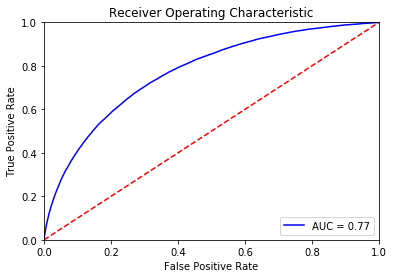

In [0]:
import sklearn.metrics as met

fpr,tpr,thresholds = met.roc_curve(y_test, preds_proba_positive)
roc_auc = met.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 평가 파일(AFSNT_DLY) 예측

### AFSNT_DLY 파일 로딩후 전처리

In [0]:
AFSNT_DLY=pd.read_csv('/content/gdrive/My Drive/test_colab/AFSNT_DLY.csv',encoding = "ISO-8859-1")
AFSNT_DLY.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE
0,2019,9,16,¿ù,ARP1,ARP3,L,L1702,A,9:05,NaN,NaN
1,2019,9,16,¿ù,ARP3,ARP1,L,L1702,D,7:55,NaN,NaN
2,2019,9,16,¿ù,`,ARP3,L,L1720,A,14:40,NaN,NaN
3,2019,9,16,¿ù,ARP3,ARP1,L,L1720,D,13:30,NaN,NaN
4,2019,9,16,¿ù,ARP4,ARP3,L,L1808,A,20:10,NaN,NaN


In [0]:
AFSNT_DLY.iloc[2,4]='ARP1'
AFSNT_DLY.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE
0,2019,9,16,¿ù,ARP1,ARP3,L,L1702,A,9:05,NaN,NaN
1,2019,9,16,¿ù,ARP3,ARP1,L,L1702,D,7:55,NaN,NaN
2,2019,9,16,¿ù,ARP1,ARP3,L,L1720,A,14:40,NaN,NaN
3,2019,9,16,¿ù,ARP3,ARP1,L,L1720,D,13:30,NaN,NaN
4,2019,9,16,¿ù,ARP4,ARP3,L,L1808,A,20:10,NaN,NaN


In [0]:
def weekdayn(Date):
  return Date.weekday()

def getValuebyminute(STT):
  hour,minute=STT.split(':')
  hour=float(hour)
  minute=float(minute)
  return hour*60+minute

# 1.통합 날짜 열 생성
AFSNT_DLY=AFSNT_DLY.rename(columns={'SDT_YY':'Year','SDT_MM':'Month','SDT_DD':'Day'})
AFSNT_DLY['DATE']=pd.to_datetime(AFSNT_DLY.loc[:, ['Year','Month','Day']])

# 2. 요일 열 생성
AFSNT_DLY['Weekday']=AFSNT_DLY['DATE'].apply(weekdayn)
AFSNT_DLY['STT']=AFSNT_DLY['STT'].apply(getValuebyminute)
AFSNT_DLY['IRR']='N'
AFSNT_DLY.head()

,Year,Month,Day,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE,DATE,Weekday,IRR
0,2019,9,16,¿ù,ARP1,ARP3,L,L1702,A,545.0,NaN,NaN,2019-09-16,0,N
1,2019,9,16,¿ù,ARP3,ARP1,L,L1702,D,475.0,NaN,NaN,2019-09-16,0,N
2,2019,9,16,¿ù,ARP1,ARP3,L,L1720,A,880.0,NaN,NaN,2019-09-16,0,N
3,2019,9,16,¿ù,ARP3,ARP1,L,L1720,D,810.0,NaN,NaN,2019-09-16,0,N
4,2019,9,16,¿ù,ARP4,ARP3,L,L1808,A,1210.0,NaN,NaN,2019-09-16,0,N


In [0]:
AFSNT_DLY2=AFSNT_DLY.loc[:,['DATE','ARP','ODP','FLO','AOD','IRR','Month','Weekday','STT','DLY','DLY_RATE']]
AFSNT_DLY2.head()

,DATE,ARP,ODP,FLO,AOD,IRR,Month,Weekday,STT,DLY,DLY_RATE
0,2019-09-16,ARP1,ARP3,L,A,N,9,0,545.0,NaN,NaN
1,2019-09-16,ARP3,ARP1,L,D,N,9,0,475.0,NaN,NaN
2,2019-09-16,ARP1,ARP3,L,A,N,9,0,880.0,NaN,NaN
3,2019-09-16,ARP3,ARP1,L,D,N,9,0,810.0,NaN,NaN
4,2019-09-16,ARP4,ARP3,L,A,N,9,0,1210.0,NaN,NaN


In [0]:
from sklearn.externals import joblib

file_name = '/content/gdrive/My Drive/test_colab/FLT/CatBoostModel.pkl'  
CatBoostModel = joblib.load(file_name)

### FLO가 M이 아닌 것과 M인것 나누기  
FLO가 M인 데이터는 학습 데이터에 없었다.  
먼저 FLO가 M이 아닌 경우를 학습 시킨 후 (AFSNT_DLY3)  
FLO가 M인 경우는(AFSNT_DLY4) 나머지 항공사의 확률의 평균으로  
대체하였다.

In [0]:
AFSNT_DLY3=AFSNT_DLY2.loc[AFSNT_DLY2['FLO']!='M']
AFSNT_DLY4=AFSNT_DLY2.loc[AFSNT_DLY2['FLO']=='M']
X3=AFSNT_DLY3.iloc[:,1:9]
X4=AFSNT_DLY4.iloc[:,1:9]

In [0]:
#FLO!='M'인 편들(X3)의 예측값()
preds3_class = CatBoostModel.predict(X3)
preds3_proba_positive = CatBoostModel.predict_proba(X3)[:,1]

X3['DLY_RATE']=np.round(preds3_proba_positive,4)
X3['DLY']=preds3_class
X3.head(10)

,ARP,ODP,FLO,AOD,IRR,Month,Weekday,STT,DLY_RATE,DLY
0,ARP1,ARP3,L,A,N,9,0,545.0,0.0755,0.0
1,ARP3,ARP1,L,D,N,9,0,475.0,0.2031,0.0
2,ARP1,ARP3,L,A,N,9,0,880.0,0.3182,0.0
3,ARP3,ARP1,L,D,N,9,0,810.0,0.7568,1.0
4,ARP4,ARP3,L,A,N,9,0,1210.0,0.3129,0.0
5,ARP3,ARP4,L,D,N,9,0,1150.0,0.3621,0.0
6,ARP3,ARP9,J,A,N,9,0,960.0,0.1186,0.0
7,ARP9,ARP3,J,D,N,9,0,900.0,0.1735,0.0
8,ARP3,ARP1,L,A,N,9,0,490.0,0.0854,0.0
9,ARP1,ARP3,L,D,N,9,0,420.0,0.1055,0.0


In [0]:
#FLO가 M인 경우, 다른 항공사들일 경우로 가정한다.
X4B=X4.copy()
X4F=X4.copy()
X4H=X4.copy()
X4I=X4.copy()
X4J=X4.copy()
X4L=X4.copy()

X4A['FLO']='A'
X4B['FLO']='B'
X4F['FLO']='F'
X4H['FLO']='H'
X4I['FLO']='I'
X4J['FLO']='J'
X4L['FLO']='L'

In [0]:
#FLO가 A,B,F,H,I,J,L인 경우의 레이블과 확률 값
preds4A_class = CatBoostModel.predict(X4A)
preds4A_proba_positive = CatBoostModel.predict_proba(X4A)[:,1]
preds4B_class = CatBoostModel.predict(X4B)
preds4B_proba_positive = CatBoostModel.predict_proba(X4B)[:,1]
preds4F_class = CatBoostModel.predict(X4F)
preds4F_proba_positive = CatBoostModel.predict_proba(X4F)[:,1]
preds4H_class = CatBoostModel.predict(X4H)
preds4H_proba_positive = CatBoostModel.predict_proba(X4H)[:,1]
preds4I_class = CatBoostModel.predict(X4I)
preds4I_proba_positive = CatBoostModel.predict_proba(X4I)[:,1]
preds4J_class = CatBoostModel.predict(X4J)
preds4J_proba_positive = CatBoostModel.predict_proba(X4J)[:,1]
preds4L_class = CatBoostModel.predict(X4L)
preds4L_proba_positive = CatBoostModel.predict_proba(X4L)[:,1]


In [0]:
#확률의 평균과 레이블 보팅(voting)
Mclass_sum = (preds4A_class+preds4B_class+preds4F_class+preds4H_class+preds4I_class+preds4J_class+preds4L_class)
preds4M_class = np.where(Mclass_sum>=4,1,0)
preds4M_proba_positive = (preds4A_proba_positive+preds4B_proba_positive+preds4F_proba_positive+preds4H_proba_positive+preds4I_proba_positive+preds4J_proba_positive+preds4L_proba_positive)/7

In [0]:
X4['DLY_RATE']=np.round(preds4M_proba_positive,4)
X4['DLY']=preds4M_class
X4.head(10)

,ARP,ODP,FLO,AOD,IRR,Month,Weekday,STT,DLY_RATE,DLY
86,ARP3,ARP10,M,A,N,9,0,685.0,0.0680,0
87,ARP10,ARP3,M,D,N,9,0,590.0,0.0021,0
92,ARP3,ARP10,M,A,N,9,0,1090.0,0.0004,0
93,ARP10,ARP3,M,D,N,9,0,1010.0,0.0113,0
193,ARP2,ARP10,M,A,N,9,0,870.0,0.0031,0
194,ARP10,ARP2,M,D,N,9,0,820.0,0.0245,0
197,ARP10,ARP2,M,A,N,9,0,965.0,0.0156,0
198,ARP2,ARP10,M,D,N,9,0,905.0,0.0014,0
1182,ARP3,ARP10,M,A,N,9,1,685.0,0.0120,0
1183,ARP10,ARP3,M,D,N,9,1,590.0,0.0016,0


### X3와 X4를 다시 합친다.

In [0]:
X=pd.concat([X3,X4])
X.sort_index(inplace=True)
X.head(10)

,ARP,ODP,FLO,AOD,IRR,Month,Weekday,STT,DLY_RATE,DLY
0,ARP1,ARP3,L,A,N,9,0,545.0,0.0755,0.0
1,ARP3,ARP1,L,D,N,9,0,475.0,0.2031,0.0
2,ARP1,ARP3,L,A,N,9,0,880.0,0.3182,0.0
3,ARP3,ARP1,L,D,N,9,0,810.0,0.7568,1.0
4,ARP4,ARP3,L,A,N,9,0,1210.0,0.3129,0.0
5,ARP3,ARP4,L,D,N,9,0,1150.0,0.3621,0.0
6,ARP3,ARP9,J,A,N,9,0,960.0,0.1186,0.0
7,ARP9,ARP3,J,D,N,9,0,900.0,0.1735,0.0
8,ARP3,ARP1,L,A,N,9,0,490.0,0.0854,0.0
9,ARP1,ARP3,L,D,N,9,0,420.0,0.1055,0.0


### 결과 파일을 불러와 DLY와 DLY_RATE를 appending 한다.

In [0]:
result=pd.read_csv('/content/gdrive/My Drive/test_colab/AFSNT_DLY.csv',encoding = "ISO-8859-1")
result['DLY']=X['DLY']
result['DLY_RATE']=X['DLY_RATE']
result.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE
0,2019,9,16,¿ù,ARP1,ARP3,L,L1702,A,9:05,0.0,0.0755
1,2019,9,16,¿ù,ARP3,ARP1,L,L1702,D,7:55,0.0,0.2031
2,2019,9,16,¿ù,`,ARP3,L,L1720,A,14:40,0.0,0.3182
3,2019,9,16,¿ù,ARP3,ARP1,L,L1720,D,13:30,1.0,0.7568
4,2019,9,16,¿ù,ARP4,ARP3,L,L1808,A,20:10,0.0,0.3129


In [0]:
result.to_csv('/content/gdrive/My Drive/test_colab/AFSNT_DLY_CatBoost.csv',index=False)